In [ ]:
import numpy as np
import quaternion as qt
import pyulog

: 

# Wczytanie danych
---

In [ ]:
def read_attitude_quaternions(log):
    """
    Read attitude from ulog file.
    Args:
        log (pyulog.ULog): PyUlog object to read.

    Returns:
        quat (np.ndarray [np.quaternion]), time_stamp (np.ndarray) :
        Attitude quaternion array, timestamp array
    """
    v_attitude = log.get_dataset('vehicle_attitude')
    data_size  = v_attitude.data['q[0]'].shape[0]
    merged     = zip(v_attitude.data['q[0]'], 
                     v_attitude.data['q[1]'],
                     v_attitude.data['q[2]'],
                     v_attitude.data['q[3]'])

    quat = np.zeros((data_size), dtype=np.quaternion)
    for i, m in enumerate(merged):
        quat[i] = np.quaternion(m[0], m[1], m[2], m[3])
    
    return quat, v_attitude.data['timestamp']


def read_nav_quaternon(log):
    """
    Read navigator from ulog file.
    Args:
        log (pyulog.ULog): PyUlog object to read.

    Returns:
        quat (np.ndarray [np.quaternion]), time_stamp (np.ndarray) :
        Navigator quaternion array, timestamp array
    """
    nav = log.get_dataset('navigator_setpoint')
    quat = qt.from_euler_angles(nav.data['sp_Roll_angle'], 
                                nav.data['sp_Pitch_angle'],
                                nav.data['sp_Yaw_angle'])
    return quat, nav.data['timestamp']


: 

In [182]:
log = pyulog.ULog('./ulogs/37_bs78_out_GPS_alt2pos.ulg')
att_q, att_t = read_attitude_quaternions(log)
nav_q, nav_t = read_nav_quaternon(log)

# Interpolacja
---

In [183]:
import numpy as np
import quaternion as qt
from quaternion.calculus import spline_evaluation
from quaternion import squad
import matplotlib.pyplot as plt

def subsequence_arg_range(att_t: np.ndarray, max_length: int) -> list:
    """
    Function find range of subsequence of data where 
    separator is max length between samples.

    Args:
        att_t (np.ndarray): One dimension array of numbers data
        max_length (int): Maximum length between samples (separator)

    Returns:
        arg_range (list): Subspaces indices
    """
    diff = np.diff(att_t)

    arg_botom = 0
    arg_top = np.argmax(diff > max_length)

    range_value = list()
    while arg_top:
        range_value.append([arg_botom, arg_botom+arg_top])
        arg_botom += arg_top + 1
        arg_top = np.argmax(diff[arg_botom+1:] > max_length)
    
    range_value.append([arg_botom, att_t.shape[0]])
    return range_value


def normalized(t_arr: np.ndarray, min: int, max: int):
    """
    Simply data normalization (`t_arr`-`min`)/(`max`-`min`)

    Args:
        t_arr (np.ndarray): Data to be normalized
        min (int): Minimum value `min`>=min(t_arr)
        max (int): Maximum value `max`<=max(t_arr)

    Returns:
        t_arr_norm (np.ndarray): Normalized data
    """
    return (t_arr - min) / (max - min)


def spline_interpolation(q_arr: np.ndarray, t_arr: np.array, t_interp_arr: np.ndarray, spline_degree: int = 1):
    """
    Interpolation quaternion by spline method

    Args:
        q_arr (np.ndarray): Quaternion data array 
        t_arr (np.array): Timestamp of `q_arr`
        t_interp_arr (np.ndarray): Timestamp of interpolated data, must be include in `t_arr` range value
        spline_degree (int, optional): Degree of spline method in range `1...5`. Defaults to 1.

    Returns:
        q_interp_arr (np.ndarray): Interpolated quaternions
    """
    if t_arr[0] > t_interp_arr[0]:
        print("Interpolated timestamp is smaller than the range of the data array")
        return
    
    if t_arr[-1] < t_interp_arr[-1]:
        print("Interpolated timestamp is bigger than the range of the data array")
        return

    # Normalization
    min_val = t_arr[0] 
    max_val = t_arr[-1]

    t_arr_norm = normalized(t_arr, min_val, max_val)
    t_interp_arr_norm = normalized(t_interp_arr, min_val, max_val)

    # Unpack quaternion
    q_arr_unpacked = qt.as_float_array(q_arr)

    # Interpolation
    q_interp_unpacked = spline_evaluation(q_arr_unpacked, t_arr_norm, t_interp_arr_norm, spline_degree=spline_degree)

    # Pack quaternion to np.quaternion and return
    return qt.from_float_array(q_interp_unpacked)


def squad_interpolation(q_arr: np.ndarray, t_arr: np.array, t_interp_arr: np.ndarray):
    """
    Interpolation quaternion by squad method, based on slerp method

    Args:
        q_arr (np.ndarray): Quaternion data array 
        t_arr (np.array): Timestamp of `q_arr`
        t_interp_arr (np.ndarray): Timestamp of interpolated data, must be include in `t_arr` range value

    Returns:
        q_interp_arr (np.ndarray): Interpolated quaternions
    """
    if t_arr[0] > t_interp_arr[0]:
        print("Interpolated timestamp is smaller than the range of the data array")
        return
    
    if t_arr[-1] < t_interp_arr[-1]:
        print("Interpolated timestamp is bigger than the range of the data array")
        return

    # Normalization
    min_val = t_arr[0] 
    max_val = t_arr[-1]

    t_arr_norm = normalized(t_arr, min_val, max_val)
    t_interp_arr_norm = normalized(t_interp_arr, min_val, max_val)

    # Interpolation
    q_interp = squad(q_arr, t_arr_norm, t_interp_arr_norm)

    # Pack quaternion to np.quaternion and return
    return q_interp


# TODO Remove or not ? 
def display_quaternion_comparison(q_1: np.ndarray, t_1: np.ndarray, q_2: np.ndarray, t_2: np.ndarray, title: str = ''):
    """
    Function only for comparison

    Args:
        q_1 (np.ndarray): _description_
        t_1 (np.ndarray): _description_
        q_2 (np.ndarray): _description_
        t_2 (np.ndarray): _description_
        title (str, optional): _description_. Defaults to ''.
    """
    TITLES = ["quaternion.w", "quaternion.x", "quaternion.y", "quaternion.z", ]
    q_1_arr = qt.as_float_array(q_1)
    q_2_arr = qt.as_float_array(q_2)

    plt.figure(figsize = (10,9))
    plt.tight_layout(pad = 5)

    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.plot(t_2, q_2_arr[:,i], label='Est')
        plt.plot(t_1, q_1_arr[:,i], label='Real')
        plt.ylabel("Value")
        plt.xlabel("Timestamp")
        plt.title(TITLES[i])
        plt.legend(loc='upper right')

    plt.suptitle(title)
    plt.show()    


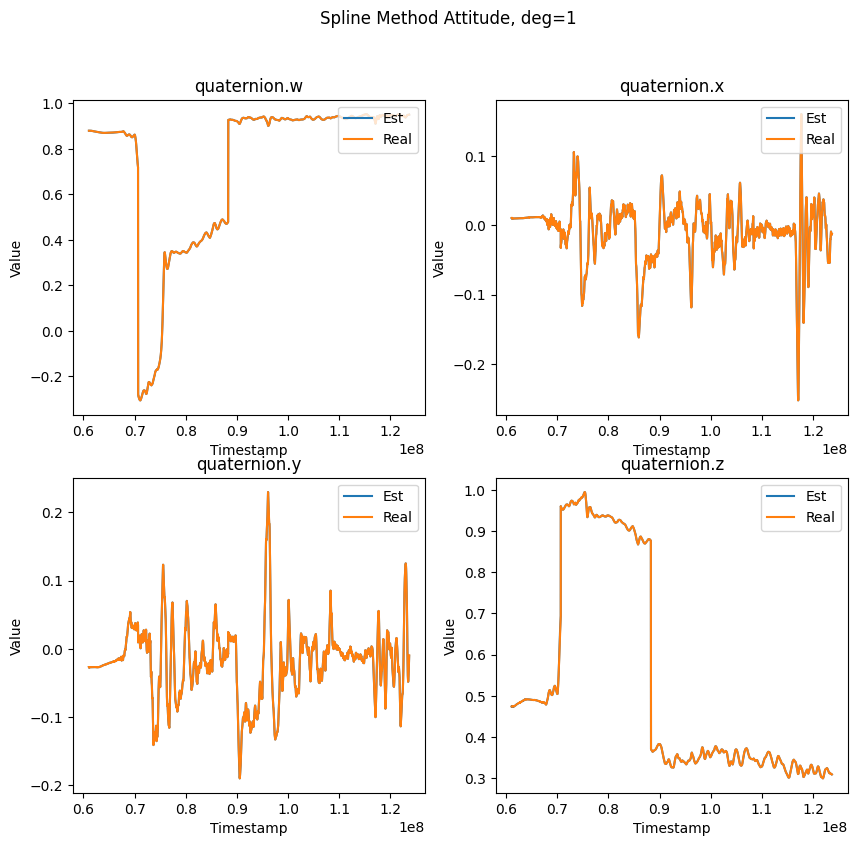

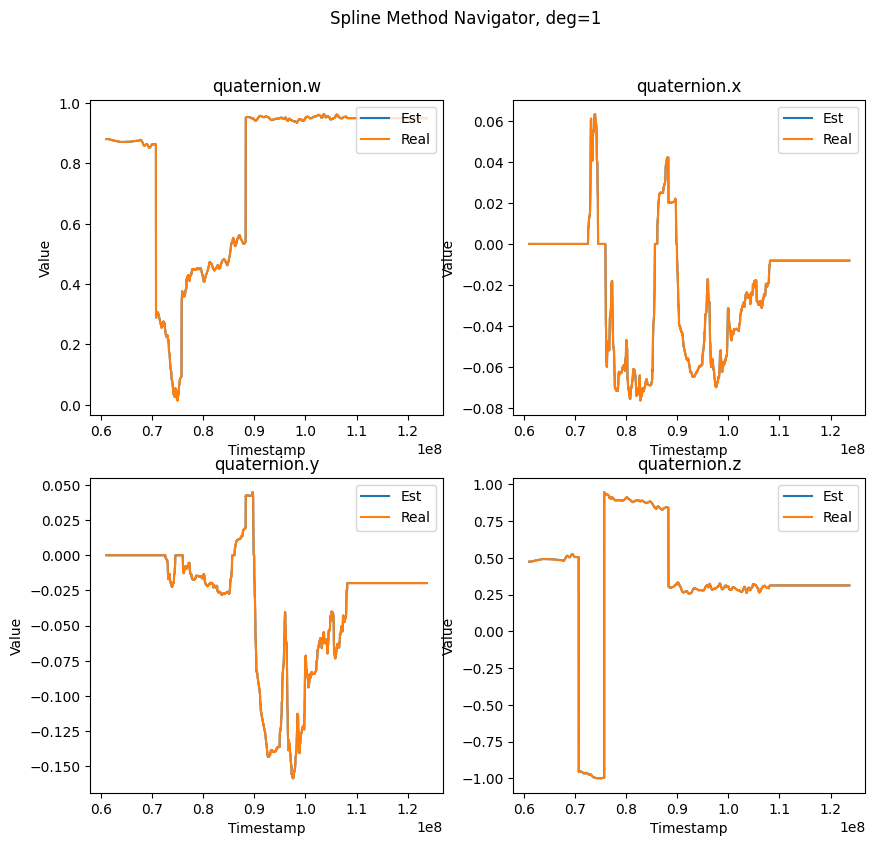

In [195]:
# How to use interpolation

# Find subsequences and split data
arg_partial_signal = subsequence_arg_range(att_t, max_length = 20e4)

att_args   = arg_partial_signal[0]
att_t_part = att_t[att_args[0]:att_args[1]]
att_q_part = att_q[att_args[0]:att_args[1]]

nav_args   = [np.argmin(nav_t < att_t_part[0]), np.argmax(nav_t > att_t_part[-1])]
nav_t_part = nav_t[nav_args[0]:nav_args[1]]
nav_q_part = nav_q[nav_args[0]:nav_args[1]]

# Find minimum and maximum
min = np.max([np.min(att_t_part), np.min(nav_t_part)])
max = np.min([np.max(att_t_part), np.max(nav_t_part)])

# Timestamp for interpolated quaternion
dt = 4000 # Time between samples
est_t_part = np.arange(min, max+1, dt)

# Interpolation
spline_degree = 1       # NOTE Best result for spline_degree = 1  
est_q_att = spline_interpolation(att_q_part, att_t_part, est_t_part) # For squad method --> squad_interpolation()
est_q_nav = spline_interpolation(nav_q_part, nav_t_part, est_t_part) # For squad method --> squad_interpolation()

# Display for check
display_quaternion_comparison(att_q_part, att_t_part, est_q_att, est_t_part, 'Spline Method Attitude, deg={}'.format(spline_degree))
display_quaternion_comparison(nav_q_part, nav_t_part, est_q_nav, est_t_part, 'Spline Method Navigator, deg={}'.format(spline_degree))

# Metody predykcji
--- 

In [190]:
def compute_correlation_matrix(windowing_signal: np.ndarray, M_order: int) -> np.ndarray :
    """
    Determines the quaternion correlation matrix.
    Args:
        windowing_signal (np.ndarray[np.quaternion]): Windowing signal
        M_order (int): Filter order

    Returns:
        np.ndarray[np.quaternion]: Corelation matrix 
    """
    n = windowing_signal.size
    r_size = M_order + 1

    r_matrix = np.zeros((r_size, r_size), dtype = np.quaternion)
    for i in range(0, (n - M_order - 1) ):
        v = windowing_signal[i : (i + M_order + 1)]
        r_matrix += np.outer(v.conjugate(), v)
    
    return r_matrix

In [191]:
def compute_coefficient_LD(r_matrix: np.ndarray, M_order: int) -> np.ndarray:
    
    a_arr = np.zeros((0), dtype = np.quaternion)
    
    # Step 1: P=0 -> a0 = 1
    # Step 2: P=1
    a_arr = np.append(a_arr, r_matrix[1,0] / r_matrix[1,1])

    # Step 3: Iterative for P in (1 : M_order)
    for i in range(1, M_order):
        nominator   = r_matrix[i+1, 0] - np.sum(a_arr * r_matrix[i, :i])
        denominator = r_matrix[i+1, i+1] - np.sum(a_arr[::-1] * r_matrix[i, :i])
        temp_a = nominator / denominator
        a_arr = np.append(a_arr, temp_a)

        # Coeff actualization 
        for j in range(i):
            a_arr[j] = a_arr[j] - temp_a * a_arr[i-j-1]
    
    return a_arr

In [158]:
def mse_error(q1, q2):
    q1_farr = qt.as_float_array(q1)
    q2_farr = qt.as_float_array(q2)

    if q1_farr.ndim > 1:
        return np.sqrt(np.sum((q1_farr-q2_farr)**2, axis=1))

    return np.sqrt(np.sum((q1_farr-q2_farr)**2))

In [196]:
N_window = 30
M_order = 3

min_lim = 3000
max_lim = 6500


predict = np.zeros((max_lim-min_lim), dtype = np.quaternion)
for i in range(min_lim, max_lim):
    r_matrix = compute_correlation_matrix(est_q_att[i-N_window : i], M_order)

    a_arr = compute_coefficient_LD(r_matrix, M_order)

    predict[i - min_lim] = np.sum(a_arr * est_q_att[i-M_order : i]).normalized()

.....MSE error......
	MSE avg: 0.0030030704069142463, 
	MSE median: 0.0022780980850651356,
	MSE max: 0.0389425572237821


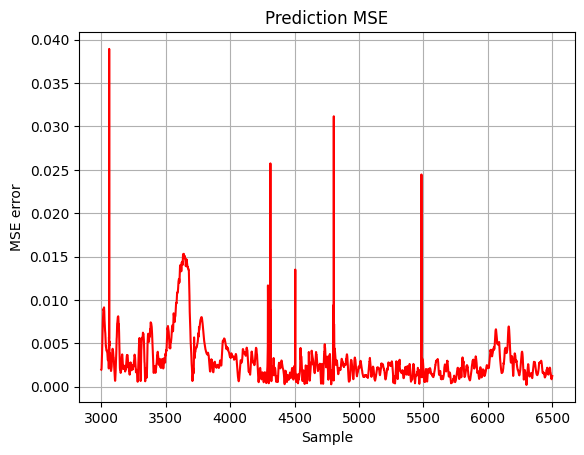

In [197]:
mse_err = mse_error(predict, est_q_att[min_lim : max_lim])

# Basic statistics
mse_err_median = np.median(mse_err)
mse_err_avg    = np.average(mse_err)
mse_err_max    = np.max(mse_err)

print("{:.^20}".format("MSE error"))
print("\tMSE avg: {}, \n\tMSE median: {},\n\tMSE max: {}".format(mse_err_avg, mse_err_median, mse_err_max))

plt.plot(range(min_lim, max_lim), mse_err, 'r')
plt.title('Prediction MSE')
plt.ylabel('MSE error')
plt.xlabel('Sample')
plt.grid()
plt.show()

.....MSE error......
	MSE angle avg : 1.3217629541942006, 
	MSE angle median: 0.5621150319558414,
	MSE angle max: 88.03930005807229


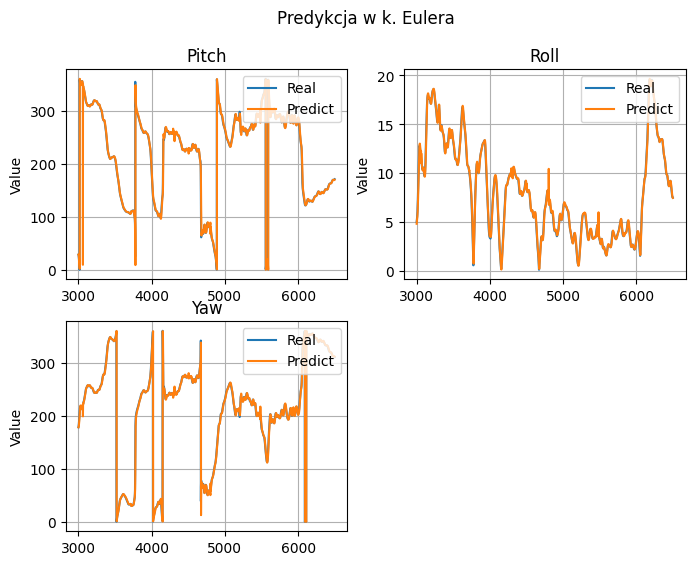

In [210]:
att_euler = qt.as_euler_angles(est_q_att[min_lim : max_lim]) * (180/np.pi) 
att_euler_angle = np.where(att_euler < 0, 360+att_euler, att_euler)
att_pre_euler = qt.as_euler_angles(predict) * (180/np.pi) 
att_pre_euler_angle = np.where(att_pre_euler < 0, 360+att_pre_euler, att_pre_euler)

mse_err_angle = np.sqrt((att_euler_angle-att_pre_euler_angle)**2)
mse_err_angle = np.abs(np.where(mse_err_angle > 180., mse_err_angle-360., mse_err_angle))
mse_err_angle_median = np.median(mse_err_angle)
mse_err_angle_avg    = np.average(mse_err_angle)
mse_err_angle_max    = np.max(mse_err_angle)

print("{:.^20}".format("MSE error"))
print("\tMSE angle avg : {}, \n\tMSE angle median: {},\n\tMSE angle max: {}".format(mse_err_angle_avg, 
                                            mse_err_angle_median, mse_err_angle_max))


TITLES = ['Pitch', 'Roll', 'Yaw']
plt.figure(figsize = (8,6))
plt.tight_layout(pad = 5)

for i in range(3):
    plt.subplot(2,2,i+1)
    plt.plot(range(min_lim, max_lim), att_euler_angle[:,i], label='Real')
    plt.plot(range(min_lim, max_lim), att_pre_euler_angle[:,i], label='Predict')
    plt.ylabel("Value")
    plt.title(TITLES[i])
    plt.grid()
    plt.legend(loc='upper right')

plt.suptitle("Predykcja w k. Eulera")
plt.show()    



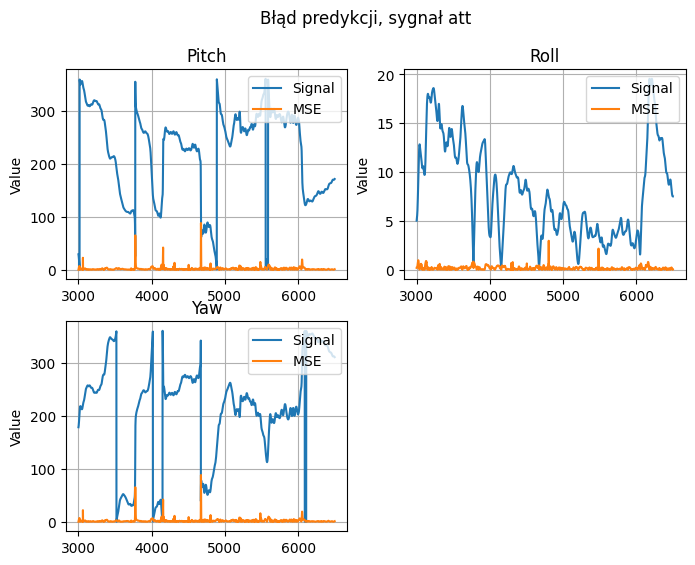

In [211]:
TITLES = ['Pitch', 'Roll', 'Yaw']
plt.figure(figsize = (8,6))
plt.tight_layout(pad = 5)

for i in range(3):
    plt.subplot(2,2,i+1)
    plt.plot(range(min_lim, max_lim), att_euler_angle[:,i], label='Signal')
    plt.plot(range(min_lim, max_lim), mse_err_angle[:,i], label='MSE')
    plt.ylabel("Value")
    plt.title(TITLES[i])
    plt.grid()
    plt.legend(loc='upper right')

plt.suptitle("Błąd predykcji, sygnał att")
plt.show()    